In this notebook, we examined the differences in connectivity changes (Incongruent vs Congruent) of both tasks, concentrating on the characteristics at the intrinsic network level.

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from os.path import join as opj
from scipy.spatial.distance import squareform
from nilearn.image import load_img
from statsmodels.stats.multitest import multipletests
from nilearn.glm.second_level import SecondLevelModel

final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)
print(n_subjects)

n_scans = 280 

rsn_networks = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv").Network
rsn_networks

rsn_names = ["MF", "FP", "DM", "SC", "MT", "V1", "V2", "VA"]

experiment_dir = Path(glob("../results/experiments/*/shen/pipeline_main.yaml")[0]).parent.as_posix()
stroop_edge_ef = glob(opj(experiment_dir, "task-stroop/edge/*/Incongruent-Congruent/effect_size.nii.gz"))
mist_edge_ef = glob(opj(experiment_dir, "task-msit/edge/*/Incongruent-Congruent/effect_size.nii.gz"))

dm = pd.DataFrame({'constant': [1]*len(stroop_edge_ef)})

second_level = SecondLevelModel()

second_level.fit(stroop_edge_ef, design_matrix=dm)
res_group_stroop = second_level.compute_contrast('constant', output_type='all')

z_edge_stroop = res_group_stroop['z_score']
z_edge_stroop = squareform(np.squeeze(z_edge_stroop.get_fdata()), checks=False)
edge_sig_stroop  = multipletests(stats.norm.sf(abs(z_edge_stroop))*2, method="bonferroni")[0]

second_level.fit(mist_edge_ef, design_matrix=dm)
res_group_msit = second_level.compute_contrast('constant', output_type='all')

z_edge_msit = res_group_msit['z_score']
z_edge_msit = squareform(np.squeeze(z_edge_msit.get_fdata()), checks=False)
edge_sig_msit  = multipletests(stats.norm.sf(abs(z_edge_msit))*2, method="bonferroni")[0]

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


242


In [2]:
def extract_within_network(net):
    rsn_within = []
    for ii in range(1, 9):
        rsn_links = net[rsn_networks==ii,:][:,rsn_networks==ii]
        rsn_within.append(squareform(rsn_links, checks=False))
    return rsn_within

def prop_links(net):
    prop_mat = np.zeros((8,8))
    sig_elems = np.sum(net)
    net = squareform(net)
    for ii in range(1, 9):
        for jj in range(ii, 9):
            mat = net[rsn_networks==ii,:][:,rsn_networks==jj]
            
            if ii==jj:
                prop_mat[ii-1,jj-1] = np.sum(squareform(mat, checks=False))
                size = len(squareform(mat, checks=False))
                prop_mat[ii-1,jj-1] /=size
            else:
                prop_mat[ii-1,jj-1] = np.sum(mat)
                prop_mat[ii-1,jj-1] /= mat.size
                
            prop_mat[jj-1, ii-1] = prop_mat[ii-1, jj-1]
    return prop_mat

In [3]:
# Generate a mask for the upper triangle
mask_up = np.triu(np.ones((8,8), dtype=bool), k=1)
mask_up
# Generate a mask for the upper triangle
mask_down = np.tril(np.ones((8,8), dtype=bool), k=-1)
mask_down

array([[False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False]])

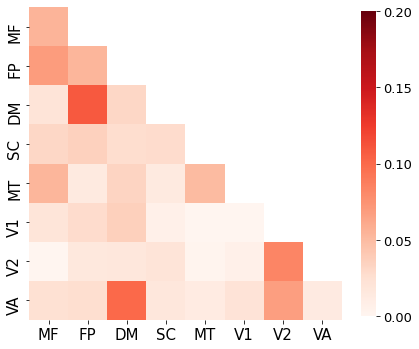

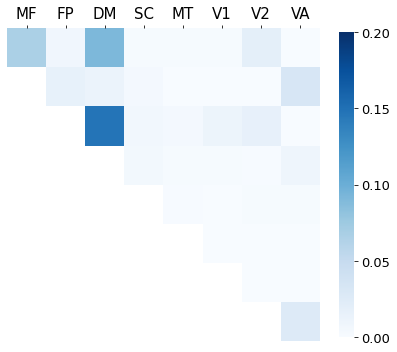

In [21]:
# Proportion of significant links (STROOP)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_stroop>0)*edge_sig_stroop), mask=mask_up, 
            cmap=plt.cm.Reds, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_pos_stroop.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_stroop.png", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_stroop.pdf", dpi=300)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_stroop<0)*edge_sig_stroop), mask=mask_down, cmap=plt.cm.Blues, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
ax.yaxis.set_tick_params(size=0)
ax.yaxis.set_ticklabels('')
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_neg_stroop.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_stroop.png", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_stroop.pdf", dpi=300)

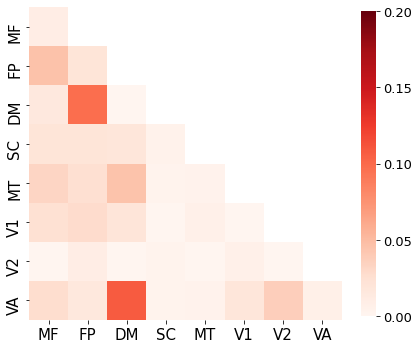

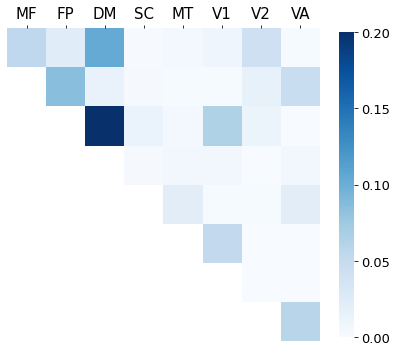

In [22]:
# Proportion of significant links (MSIT)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_msit>0)*edge_sig_msit), mask=mask_up, 
            cmap=plt.cm.Reds, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_pos_msit.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_msit.png", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_msit.pdf", dpi=300)


fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_msit<0)*edge_sig_msit), mask=mask_down, cmap=plt.cm.Blues, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
ax.yaxis.set_tick_params(size=0)
ax.yaxis.set_ticklabels('')
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_neg_msit.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_msit.png", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_msit.pdf", dpi=300)

Show that both tasks have a different concentration of negative and positive links

In [23]:
thr_stroop = np.percentile(abs(z_edge_stroop), 99.)
thr_msit = np.percentile(abs(z_edge_msit), 99.)

In [24]:
prop_table = [[sum(z_edge_stroop[abs(z_edge_stroop)>thr_stroop]>0), 
                     sum(z_edge_stroop[abs(z_edge_stroop)>thr_stroop]<0)],
                    [sum(z_edge_msit[abs(z_edge_msit)>thr_msit]>0), 
                     sum(z_edge_msit[abs(z_edge_msit)>thr_msit]<0)]]
print(prop_table)
stats.fisher_exact(prop_table)

[[305, 53], [209, 149]]


(4.1026451205199965, 1.1706710554464264e-15)

In [25]:
prop_table = [[sum(z_edge_stroop[edge_sig_stroop]>0), 
                     sum(z_edge_stroop[edge_sig_stroop]<0)],
                    [sum(z_edge_msit[edge_sig_msit]>0), 
                     sum(z_edge_msit[edge_sig_msit]<0)]]
print(prop_table)
stats.fisher_exact(prop_table)


[[1024, 260], [581, 461]]


(3.125009929829207, 1.8672669608714598e-35)

In [26]:
print(sum(edge_sig_stroop))
print(sum(edge_sig_msit))

1284
1042
